In [26]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import gc
import math

In [2]:
#Params
input_size=500
batch_size=512
nbr_epochs=5
data_split_ratio=0.8
chunksize = 100000
lr = 0.001
y_column = "300s"
files_x = ["data/x_Swedbank_A_500_p.csv",]
files_y = ["data/y_Swedbank_A_500.csv",]

In [3]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    dev_data_x = torch.tensor(xs[t:].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:].values, dtype=torch.float32)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y)

In [4]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [5]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [6]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1000).type(dtype)
        nn.init.normal(self.fc1.weight, mean=0, std=1)
        self.fc1.weight = nn.Parameter(self.fc1.weight * math.sqrt(2/input_size))
        self.fc2 = nn.Linear(1000, 2000).type(dtype)
        nn.init.normal(self.fc2.weight, mean=0, std=1)
        self.fc2.weight = nn.Parameter(self.fc2.weight * math.sqrt(2/input_size))
        self.fc3 = nn.Linear(2000, 1000).type(dtype)
        nn.init.normal(self.fc3.weight, mean=0, std=1)
        self.fc3.weight = nn.Parameter(self.fc3.weight * math.sqrt(2/input_size))
        self.fc4 = nn.Linear(1000, 500).type(dtype)
        nn.init.normal(self.fc4.weight, mean=0, std=1)
        self.fc4.weight = nn.Parameter(self.fc4.weight * math.sqrt(2/input_size))
        self.fc5 = nn.Linear(500, 100).type(dtype)
        nn.init.normal(self.fc5.weight, mean=0, std=1)
        self.fc5.weight = nn.Parameter(self.fc5.weight * math.sqrt(2/input_size))
        self.fc6 = nn.Linear(100, 20).type(dtype)
        nn.init.normal(self.fc6.weight, mean=0, std=1)
        self.fc6.weight = nn.Parameter(self.fc6.weight * math.sqrt(2/input_size))
        self.fc7 = nn.Linear(20, 1).type(dtype)
        nn.init.normal(self.fc7.weight, mean=0, std=1)
        self.fc7.weight = nn.Parameter(self.fc7.weight * math.sqrt(2/input_size))
        
        self.bn1 = nn.BatchNorm1d(num_features=input_size, track_running_stats=False)
        self.sig = nn.Sigmoid()
        
        self.drop_layer = nn.Dropout(p=0.010)
    
    def forward(self, x):
        x = self.sig(self.bn1(x))
        fc1 = self.fc1(x)
        x = F.relu(fc1)
        #x = self.drop_layer(x)
        #print(fc1)
        #print(x)
        x = F.relu(self.fc2(x))
        #x = self.drop_layer(x)
        #print(x)
        x = F.relu(self.fc3(x))
        #x = self.drop_layer(x)
        #x = self.drop_layer(x)
        #print(x)
        x= F.relu(self.fc4(x))
        #print(y)
        x = F.relu(self.fc5(x))
        #x = self.drop_layer(x)
        x = F.relu(self.fc6(x))
        y = F.relu(self.fc7(x))
        return y

In [7]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [8]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            
            pred = model(x)

            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [9]:
def train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size):
    train_data, dev_data = splitData(x_data, y_data, data_split_ratio)
    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
    

In [10]:
#Start training
model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
test_data_x = pd.DataFrame()
test_data_y = pd.DataFrame()
for i in range(len(files_x)):
    print("Current file: " + files_x[i])
    total_rows = sum(1 for row in open(files_x[i], 'r'))
    number_of_loops = int(total_rows/chunksize)
    print("Number of chunks: " + str(number_of_loops))
    current_loop = 0
    with pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)], chunksize=chunksize) as reader_x,\
    pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int}, chunksize=chunksize) as reader_y:
        for chunk_x, chunk_y in zip(reader_x, reader_y):
            print("Progress: " + "{:.2f}".format(100 * current_loop/number_of_loops) + "%")
            x_data = chunk_x
            y_data = chunk_y
            if(current_loop < data_split_ratio * number_of_loops):
                y_data = y_data[y_column]
                train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size)
            else:
                print("Append test data")
                test_data_x = test_data_x.append(x_data)
                test_data_y = test_data_y.append(y_data)
            current_loop+=1

test_data_x = torch.tensor(test_data_x.values, dtype=torch.float32)
test_data_y = torch.tensor(test_data_y[y_column].values, dtype=torch.float32)
test_data = TensorDataset(test_data_x, test_data_y)
#test_data_y = test_data_y[y_column]
#test_data = list(zip(test_data_x, test_data_y))
#for i in range(len(files_x)):
#    x_data = pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)])
#    y_data = pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int})
#    y_data = y_data[y_column]
#    print(x_data.shape)
#    print(y_data.shape)
#    x_data.head()
#    y_data.head()
#    print(files_x[i])
#    train_data, dev_data, test_data = splitData(x_data, y_data, data_split_ratio)
#    train_data_loader = DataLoader(train_data, batch_size=batch_size)
#    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
#    model = model.to(device)
#    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
#    del [[x_data, y_data, train_data, dev_data, train_data_loader, dev_data_loader]]
#    gc.collect()



/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # This is added back by InteractiveShellApp.init_path()
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.normal is now deprecated i

Current file: data/x_Swedbank_A_500_p.csv
Number of chunks: 31


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 0.00%


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Epoch 0 	Loss: 1116.759 	Loss (val): 702.076
Epoch 1 	Loss: 358.521 	Loss (val): 640.376
Epoch 2 	Loss: 279.040 	Loss (val): 418.405
Epoch 3 	Loss: 188.754 	Loss (val): 287.369
Epoch 4 	Loss: 82.968 	Loss (val): 42.472
Progress: 3.23%
Epoch 0 	Loss: 30.758 	Loss (val): 31.601
Epoch 1 	Loss: 20.489 	Loss (val): 26.276
Epoch 2 	Loss: 20.603 	Loss (val): 8.711
Epoch 3 	Loss: 16.502 	Loss (val): 7.850
Epoch 4 	Loss: 15.084 	Loss (val): 7.087
Progress: 6.45%
Epoch 0 	Loss: 10.757 	Loss (val): 21.033
Epoch 1 	Loss: 11.298 	Loss (val): 23.895
Epoch 2 	Loss: 10.277 	Loss (val): 16.002
Epoch 3 	Loss: 10.081 	Loss (val): 20.798
Epoch 4 	Loss: 9.634 	Loss (val): 17.573
Progress: 9.68%
Epoch 0 	Loss: 8.748 	Loss (val): 5.248
Epoch 1 	Loss: 6.920 	Loss (val): 4.021
Epoch 2 	Loss: 5.857 	Loss (val): 3.677
Epoch 3 	Loss: 5.369 	Loss (val): 10.020
Epoch 4 	Loss: 5.722 	Loss (val): 3.240
Progress: 12.90%
Epoch 0 	Loss: 9.079 	Loss (val): 15.796
Epoch 1 	Loss: 7.731 	Loss (val): 23.485
Epoch 2 	Loss: 7.

In [11]:
test_data_loader = DataLoader(test_data, batch_size=batch_size)
_, preds = evaluate_model(test_data_loader, model, loss_fn)

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([389])) that is different to the input size (torch.Size([389, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


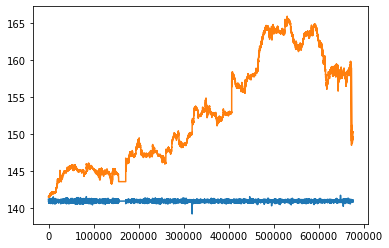

In [30]:
items_plot = test_data_y
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
#axes.set_ylim([20000,25000])
#axes.set_xlim([260000,261200])
#axes.set_xlim([100000,120000])
#axes.set_xlim([140000,160000])

#axes.set_xlim([540000,560000])
#axes.set_xlim([610000,660000])
plt.show()